In [4]:
import pandas as pd

file_path = 'miami-housing.csv'
data = pd.read_csv(file_path)

#информация и первые строки данных
data_info = data.info()
data_head = data.head()

data_info, data_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13932 entries, 0 to 13931
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   LATITUDE           13932 non-null  float64
 1   LONGITUDE          13932 non-null  float64
 2   PARCELNO           13932 non-null  int64  
 3   SALE_PRC           13932 non-null  float64
 4   LND_SQFOOT         13932 non-null  int64  
 5   TOT_LVG_AREA       13932 non-null  int64  
 6   SPEC_FEAT_VAL      13932 non-null  int64  
 7   RAIL_DIST          13932 non-null  float64
 8   OCEAN_DIST         13932 non-null  float64
 9   WATER_DIST         13932 non-null  float64
 10  CNTR_DIST          13932 non-null  float64
 11  SUBCNTR_DI         13932 non-null  float64
 12  HWY_DIST           13932 non-null  float64
 13  age                13932 non-null  int64  
 14  avno60plus         13932 non-null  int64  
 15  month_sold         13932 non-null  int64  
 16  structure_quality  139

(None,
     LATITUDE  LONGITUDE      PARCELNO  SALE_PRC  LND_SQFOOT  TOT_LVG_AREA  \
 0  25.891031 -80.160561  622280070620  440000.0        9375          1753   
 1  25.891324 -80.153968  622280100460  349000.0        9375          1715   
 2  25.891334 -80.153740  622280100470  800000.0        9375          2276   
 3  25.891765 -80.152657  622280100530  988000.0       12450          2058   
 4  25.891825 -80.154639  622280100200  755000.0       12800          1684   
 
    SPEC_FEAT_VAL  RAIL_DIST  OCEAN_DIST  WATER_DIST  CNTR_DIST  SUBCNTR_DI  \
 0              0     2815.9     12811.4       347.6    42815.3     37742.2   
 1              0     4359.1     10648.4       337.8    43504.9     37340.5   
 2          49206     4412.9     10574.1       297.1    43530.4     37328.7   
 3          10033     4585.0     10156.5         0.0    43797.5     37423.2   
 4          16681     4063.4     10836.8       326.6    43599.7     37550.8   
 
    HWY_DIST  age  avno60plus  month_sold  stru

### Построение линейной модели:

1.   Использовать критерий значимости признаков (p-value или веса)
2.   Применить жадный алгоритм отбора признаков


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

#отделим целевую переменную и признаки
X = data.drop(columns=["SALE_PRC", "PARCELNO"])  # Исключаем целевую и ненужную колонку
y = data["SALE_PRC"]

#разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#жадный алгоритм отбора признаков на основе p-value
def greedy_feature_selection(X, y, significance_level=0.05):
    selected_features = []
    remaining_features = list(X.columns)
    while remaining_features:
        p_values = []
        for feature in remaining_features:
            X_selected = X[selected_features + [feature]]
            X_selected = sm.add_constant(X_selected)
            model = sm.OLS(y, X_selected).fit()
            p_values.append((feature, model.pvalues[feature]))

        #выберем признак с минимальным p-value
        feature, p_value = min(p_values, key=lambda x: x[1])
        if p_value < significance_level:
            selected_features.append(feature)
            remaining_features.remove(feature)
        else:
            break
    return selected_features

#применяем алгоритм
selected_features = greedy_feature_selection(X_train, y_train)
selected_features

['LND_SQFOOT',
 'TOT_LVG_AREA',
 'LONGITUDE',
 'SUBCNTR_DI',
 'structure_quality',
 'LATITUDE',
 'SPEC_FEAT_VAL',
 'age',
 'RAIL_DIST',
 'HWY_DIST',
 'OCEAN_DIST',
 'CNTR_DIST',
 'avno60plus']

In [6]:
#обучим линейную модель на отобранных признаках
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

model = LinearRegression()
model.fit(X_train_selected, y_train)

#прогнозируем на тестовой выборке
y_pred = model.predict(X_test_selected)

#оценим качество модели
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

rmse

174821.3164207414

### Модель с Lasso-регуляризацией – оценить влияние параметра alpha на зануление признаков



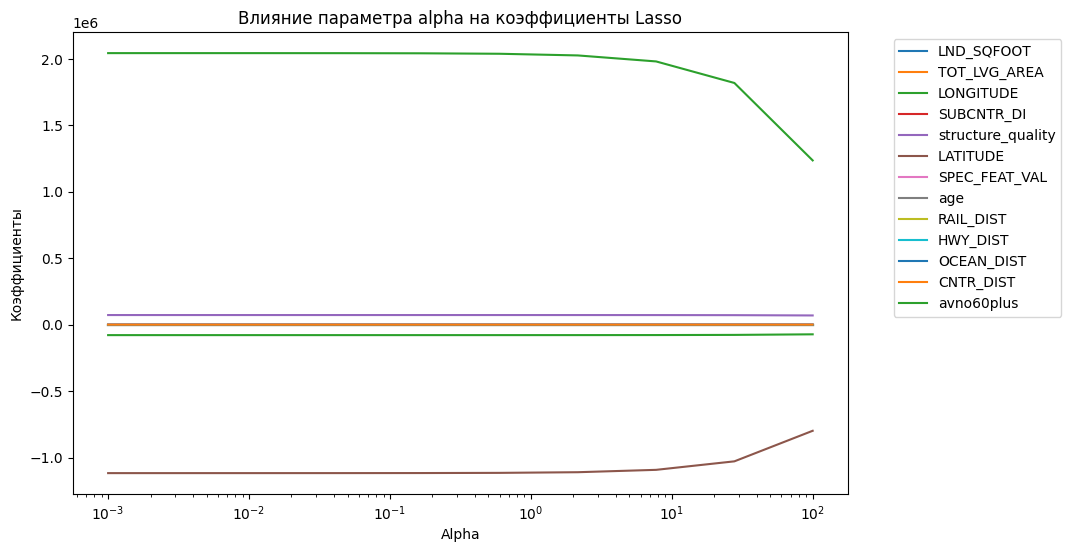

In [7]:
from sklearn.linear_model import Lasso
import numpy as np
import matplotlib.pyplot as plt

#список значений alpha
alphas = np.logspace(-3, 2, 10)

coefficients = []

#обучаем модель Lasso для каждого значения alpha
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train_selected, y_train)
    coefficients.append(lasso.coef_)

#преобразуем коэффициенты в DataFrame
coef_df = pd.DataFrame(coefficients, columns=selected_features, index=alphas)

#визуализация зануления коэффициентов
plt.figure(figsize=(10, 6))
for feature in selected_features:
    plt.plot(coef_df.index, coef_df[feature], label=feature)
plt.xscale("log")
plt.xlabel("Alpha")
plt.ylabel("Коэффициенты")
plt.title("Влияние параметра alpha на коэффициенты Lasso")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Построение моделей на основе деревьев решений:
1.   Случайный лес
2.   Градиентный бустинг



In [8]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

#обучение и предсказание для Случайного Леса
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_selected, y_train)
rf_predictions = rf_model.predict(X_test_selected)

#RMSE для Случайного Леса
rf_rmse = mean_squared_error(y_test, rf_predictions, squared=False)

#обучение и предсказание для Градиентного Бустинга
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train_selected, y_train)
gb_predictions = gb_model.predict(X_test_selected)

#RMSE для Градиентного Бустинга
gb_rmse = mean_squared_error(y_test, gb_predictions, squared=False)

rf_rmse, gb_rmse

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(95423.26093733516, 99356.45376972508)

100%|===================| 2779/2787 [05:31<00:00]       

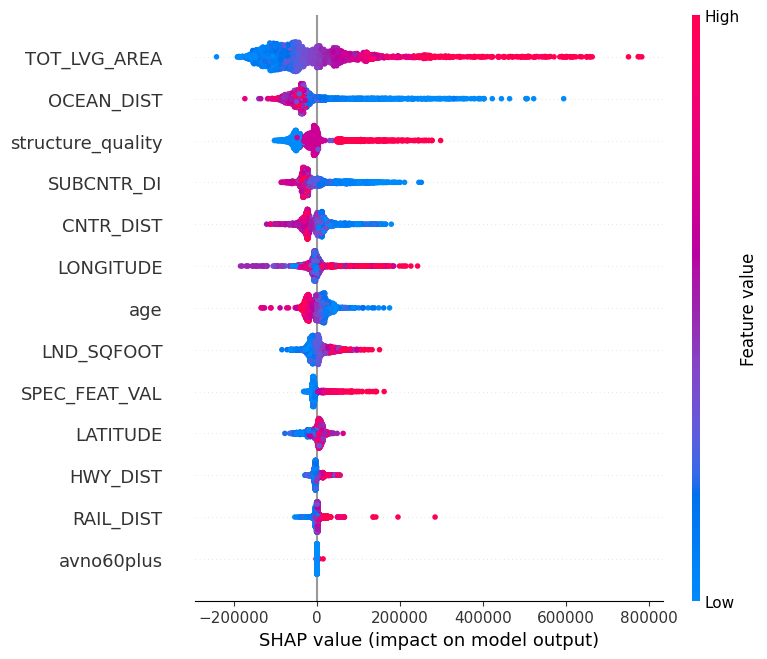

In [9]:
import shap
explainer = shap.Explainer(rf_model, X_test_selected)
shap_values = explainer(X_test_selected)

#визуализация SHAP
shap.summary_plot(shap_values, X_test_selected)

### Визуализировать отсортированную значимость признаков для каждого алгоритма (Используя встроенные методы моделей (например, feature_importances_))

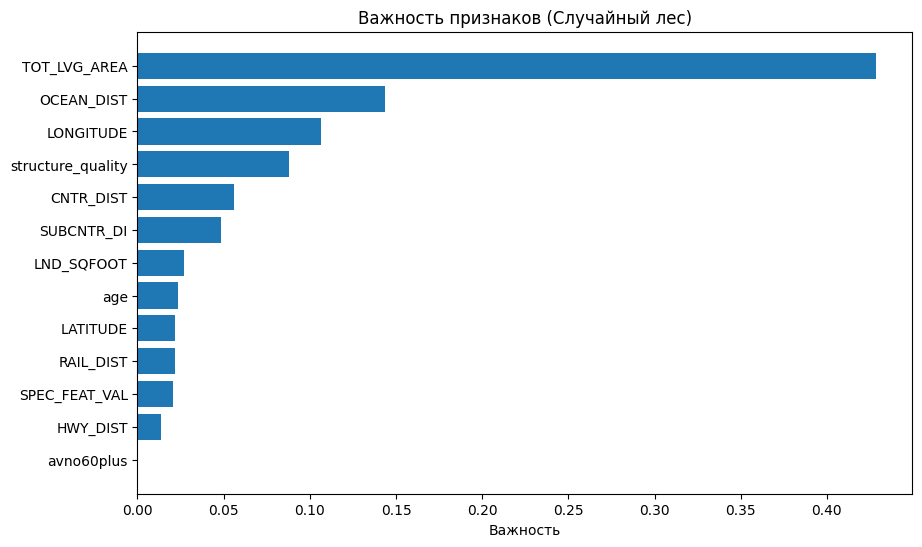

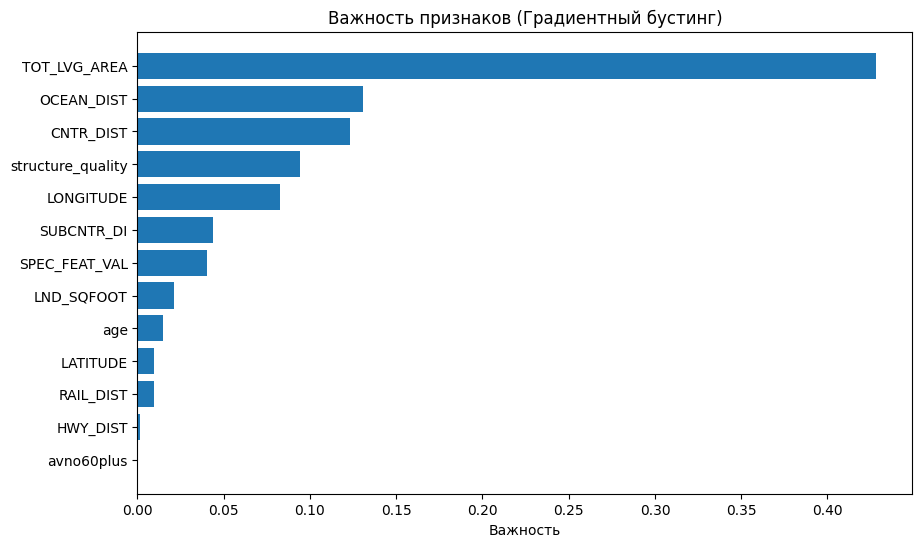

In [ ]:
#пересчитаем важность признаков для случайного леса и градиентного бустинга
rf_importances = rf_model.feature_importances_
rf_importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': rf_importances})
rf_importance_df = rf_importance_df.sort_values(by='Importance', ascending=False)

gb_importances = gb_model.feature_importances_
gb_importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': gb_importances})
gb_importance_df = gb_importance_df.sort_values(by='Importance', ascending=False)

#визуализация для случайного леса
plt.figure(figsize=(10, 6))
plt.barh(rf_importance_df['Feature'], rf_importance_df['Importance'])
plt.xlabel("Важность")
plt.title("Важность признаков (Случайный лес)")
plt.gca().invert_yaxis()
plt.show()

#визуализация для градиентного бустинга
plt.figure(figsize=(10, 6))
plt.barh(gb_importance_df['Feature'], gb_importance_df['Importance'])
plt.xlabel("Важность")
plt.title("Важность признаков (Градиентный бустинг)")
plt.gca().invert_yaxis()
plt.show()

### Оценить качество моделей:

1.   На всех признаках
2.   На основе наиболее значимых признаков

In [ ]:
#топ-5 наиболее значимых признаков для случайного леса и градиентного бустинга
top_features_rf = rf_importance_df_sorted['Feature'].tail(5).tolist()
top_features_gb = gb_importance_df_sorted['Feature'].tail(5).tolist()

#данные с топ-5 признаками
X_train_top_rf = X_train[top_features_rf]
X_test_top_rf = X_test[top_features_rf]

X_train_top_gb = X_train[top_features_gb]
X_test_top_gb = X_test[top_features_gb]

#обучение и предсказание на всех признаках и топ-5 признаках для случайного леса
rf_model_all = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_all.fit(X_train_selected, y_train)
rf_all_predictions = rf_model_all.predict(X_test_selected)
rf_rmse_all = mean_squared_error(y_test, rf_all_predictions, squared=False)

rf_model_top = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_top.fit(X_train_top_rf, y_train)
rf_top_predictions = rf_model_top.predict(X_test_top_rf)
rf_rmse_top = mean_squared_error(y_test, rf_top_predictions, squared=False)

#обучение и предсказание на всех признаках и топ-5 признаках для градиентного бустинга
gb_model_all = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model_all.fit(X_train_selected, y_train)
gb_all_predictions = gb_model_all.predict(X_test_selected)
gb_rmse_all = mean_squared_error(y_test, gb_all_predictions, squared=False)

gb_model_top = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model_top.fit(X_train_top_gb, y_train)
gb_top_predictions = gb_model_top.predict(X_test_top_gb)
gb_rmse_top = mean_squared_error(y_test, gb_top_predictions, squared=False)

#возвращаем результаты
rf_rmse_all, rf_rmse_top, gb_rmse_all, gb_rmse_top

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

(95423.26093733516, 106245.58199914759, 99356.45376972508, 113721.89422885409)

### Применить метод PCA, обучить модель на преобразованных признаках

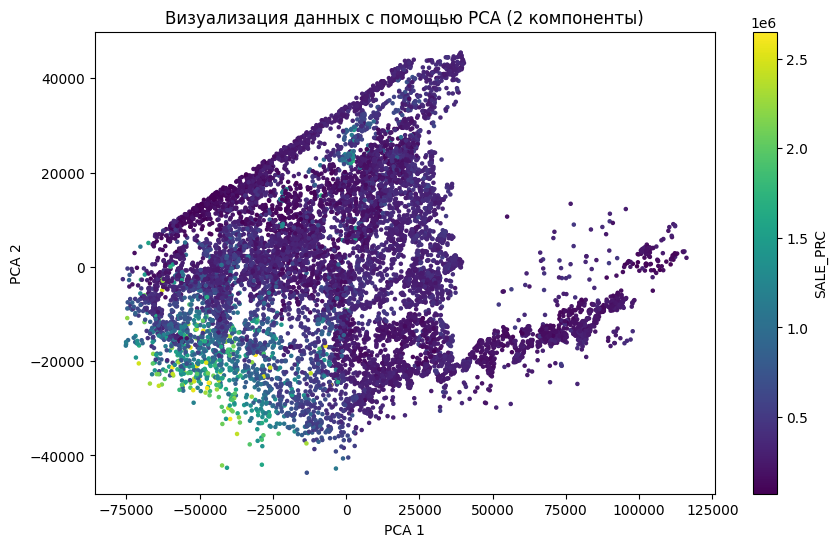

In [ ]:
from sklearn.decomposition import PCA

#применение PCA для 2 компонент
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_train_selected)

#визуализация первых двух компонент PCA
plt.figure(figsize=(10, 6))
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y_train, cmap='viridis', s=5)
plt.colorbar(label='SALE_PRC')
plt.title("Визуализация данных с помощью PCA (2 компоненты)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

### Визуализировать данные с помощью UMAP

In [ ]:
pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.6 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


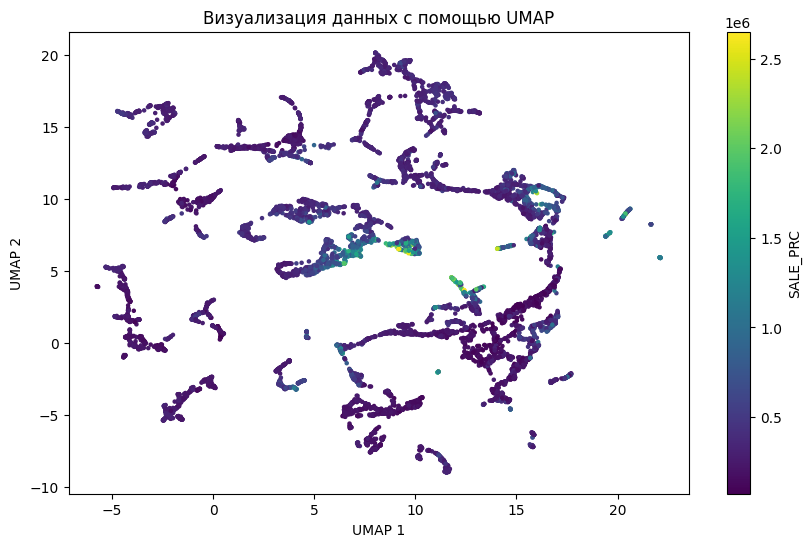

In [ ]:
import umap.umap_ as umap

#применение UMAP для уменьшения размерности до 2D
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap_2d = umap_model.fit_transform(X_train_selected)

#визуализация UMAP
plt.figure(figsize=(10, 6))
plt.scatter(X_umap_2d[:, 0], X_umap_2d[:, 1], c=y_train, cmap='viridis', s=5)
plt.colorbar(label='SALE_PRC')
plt.title("Визуализация данных с помощью UMAP")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()